# Data Viz and Analysis on the LeaderBoard
 
I'm Parker Burchett (MrQuantsALot) and created this notebook to figure out if participating in this tournament is the type of challenge I had a reasonable shot at being successful at. 
 
The beautiful thing about blockchain is that since everything is public and anonymous you can just look at the data to get a real answer. After spending a few days writing this, I am pretty sure that I have a reasonable chance and creating a profitable model.
 
I looked at the characteristics and distribution of successful users. 
 
If you have any feedback or suggestions please let me know on the forum. I am still a novice at this kind of analysis and I am sure there are things that I missed or misinterpreted. In particular, I don't know why there is a negative coefficient on the FNC -> 3M_returns OLS regression. 
 
This notebook does the following when you run it:
 
1. Query the [Numerai Leaderboard](https://numer.ai/tournament) and cast it as a Pandas Dataframe.
2. Visualize the relationship between the stake size, performance metrics and returns. 
3. OLS Regression on Returns.  
 
All of the methods are written such that you can change the dependent and independent variables. I included the visualizations I thought were interesting but you can check out the other variables yourself. The numbers will change as the leaderboard updates. 
 

In [ ]:
!pip install numpy
!pip install pandas 
!pip install json 
!pip install requests 
!pip install matplotlib
!pip install statsmodels 
%matplotlib inline

ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


# Import packages

In [ ]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Ping the Leaderboard

In [ ]:
def get_leaderboard() -> pd.DataFrame:
    """
        Ping the Numerai leaderboard and return a Pandas DataFrame of the contents.
    """
    url = 'https://api-tournament.numer.ai/'
    # this is a Graphql query, that lets me get exactly and only the data I want. 
    query = """{ 
    v2Leaderboard {
        returns
        corrRep
        fncRep
        mmcRep
        username
        nmrStaked
        returns 
        return_52Weeks
        return_13Weeks
        rank
        }  
    }"""
    r = requests.post(url=url, json={'query': query})
    json_data = json.loads(r.text)
    df_data = json_data['data']['v2Leaderboard']
    df = pd.DataFrame(df_data)
    df.convert_dtypes() # the auto casts the columns into what it thinks is the most appropriate 
    df['nmrStaked'] = pd.to_numeric(df['nmrStaked'])
 
    #Renaming the columns
    df = df.rename(columns={'returns': '1D_returns', 'return_13Weeks': '3M_returns', 'return_52Weeks': '1Y_returns'})
    return df
 
df =  get_leaderboard()
print(df.count())
df.head(10)
 
 



corrRep       5126
fncRep        5126
mmcRep        5126
nmrStaked     5126
rank          5126
3M_returns    1871
1Y_returns     398
1D_returns    2395
username      5126
dtype: int64


,corrRep,fncRep,mmcRep,nmrStaked,rank,3M_returns,1Y_returns,1D_returns,username
0,0.051317,0.012655,0.023534,775.855097,1,154.676723,NaN,-3.529810,quantyquant
1,0.049374,0.007667,0.022452,931.557869,2,161.393898,519.608612,2.731775,benben11
2,0.046950,0.023869,0.019093,95.382757,3,49.330328,204.339806,-4.489362,labrat
3,0.042120,0.016383,0.023607,0.012556,4,NaN,NaN,-1.832958,hb_falcon
4,0.041836,0.015358,0.017292,0.000000,5,NaN,NaN,1.043646,uuazed4
5,0.041786,0.017722,0.014144,0.000000,6,NaN,NaN,NaN,ezekiel_47_v12
6,0.041736,0.008361,0.015751,8.080057,7,109.702176,NaN,0.598131,uuazed6
7,0.041046,0.008594,0.015108,10.745454,8,126.733495,NaN,0.306867,uuazed5
8,0.040878,0.005091,0.014651,0.000000,9,NaN,NaN,NaN,anna13
9,0.040820,0.006613,0.016309,28.808806,10,95.969612,NaN,1.567979,junyou


# Methods to create plots

### Each method has the optional param min_stake. Use it to exclude smaller stakeing users. 


In [ ]:
def create_histogram(df, col='corrRep', bins=50, min_stake=0, max_stake=1000000):
    x = df[((df[col].notnull()) & (df['nmrStaked'] > min_stake)) & (df['nmrStaked'] < max_stake)][col]
    plt.hist(x, bins, label=f'{col} when nmrStaked>{min_stake}', alpha=.5)
    plt.xlabel(col)
    plt.ylabel('Count')
    num_elements = x.count()    
    return plt
 
def create_scatter_plot(df, x_name='corrRep', y_name='fncRep', min_stake=0, max_stake=1000000):
 
    # these are ugly one liners if you are unfamiliar with pandas.
    # They select a subset of the Dataframe df based on compound booleans. Think of them as SELECT x_name WHERE bool1, bool2... if you were writing SQL
    # (df[x_name].notnull()) get rows when x_name is not null
    # df['nmrStaked'] > min_stake) get rows where the stake is greater than the min_stake
    # df['nmrStaked'] < max_stake) get rows where the stake is less than the max stake
    # [x_name] says only give me the column with name x_name
    x = df[((df[x_name].notnull()) & (df['nmrStaked'] > min_stake)) & (df['nmrStaked'] < max_stake)][x_name]
    y = df[((df[y_name].notnull()) & (df['nmrStaked'] > min_stake)) & (df['nmrStaked'] < max_stake)][y_name]
    plt.scatter(x, y, s=.5)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    num_elements = x.count()
    plt.title(
        f'{y_name} v {x_name} when nmrStaked>{min_stake}\n Number of Elements:{num_elements}'
    )
    return plt
 
plt.rcParams["figure.figsize"] = (6,6) # changes the default size of the graphs

## Histogram of 3 Month Returns by Stake Size

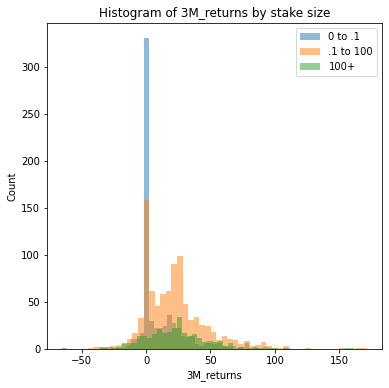

In [ ]:
col = '3M_returns' # change this to be '1D_returns' or '1Y_returns' or 'corrRep', 'fncRep' to see other distributions

create_histogram(df,col=col, min_stake=0, max_stake=.1)
create_histogram(df,col=col, min_stake=.1, max_stake=100)
create_histogram(df, col=col,min_stake=100, max_stake=1000000)

plt.legend(['0 to .1','.1 to 100','100+'])
plt.title(f'Histogram of {col} by stake size')
plt.show()

## Histogram of 3 Month returns excluding where stake is < .1

### This excludes everyone that is only betting the free .01 NMR given out. Staking .1 NMR is only about $4 right now so it is not much of a cut off. You can change up these values is reduce who you are looking at. 



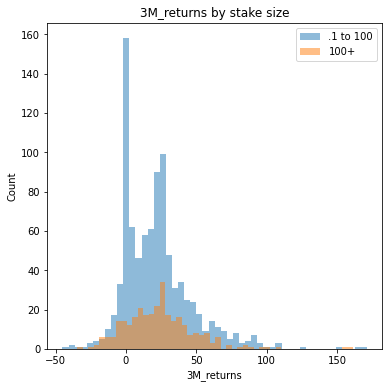

In [ ]:
col = '3M_returns'

create_histogram(df,col=col, min_stake=.1, max_stake=100)
create_histogram(df, col=col,min_stake=100, max_stake=1000000)

plt.legend(['.1 to 100','100+'])
plt.title(f'{col} by stake size')
plt.show()

## Histogram of Corr by Stake Size
 
- This forms a bimodal distribution at corrRep = -.1 and corrRep = ~+.025
- I suspect the cluster at exactly corrRep =-.1 is because every score worse than that is recorded as -.1. This would prevent a savvy person from figuring the actual true predictions by submitting a whole bunch of different submissions and then comparing the Corr scores. I don’t know that for certain but it's the best explanation I can think of.


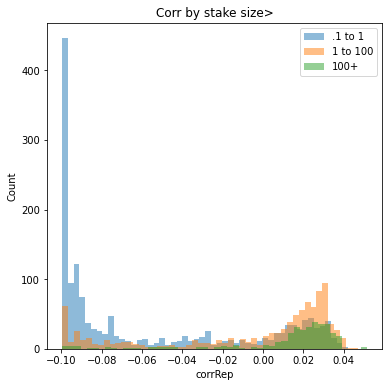

In [ ]:
col = 'corrRep'

create_histogram(df,col=col, min_stake=0, max_stake=1)
create_histogram(df,col=col, min_stake=1, max_stake=100)
create_histogram(df, col=col,min_stake=100, max_stake=1000000)

plt.legend(['.1 to 1','1 to 100','100+'])
plt.title("Corr by stake size>")
plt.show()

# Scatter Plots


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

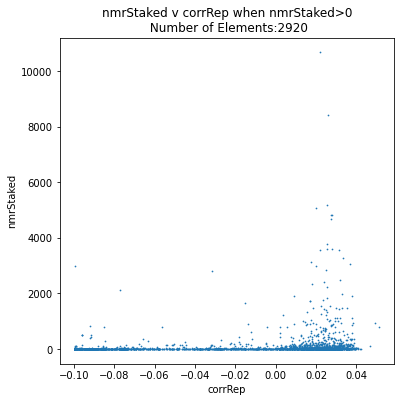

In [ ]:
create_scatter_plot(df, x_name='corrRep', y_name='nmrStaked')

# Methods to for Ordinary Least Squares Regression
 
## [Read about OLS on Wikipedia](https://en.wikipedia.org/wiki/Ordinary_least_squares)
### I am primarily interested in the relationship between stake size and returns. From an economics perspective one would expect people to bet more money on models that have a higher correlation score. This would mean a positive correlation between stake size and returns. 
 



In [ ]:
def compute_single_regression(df,
                              independent_variable='corrRep',
                              dependent_variable='3M_returns',
                              min_stake=0):

    x = df[(df[dependent_variable].notnull())
           & (df['nmrStaked'] > min_stake)][independent_variable]
    y = df[(df[dependent_variable].notnull())
           & (df['nmrStaked'] > min_stake)][dependent_variable]
    model = sm.OLS(y, x)
    results = model.fit()
    return results


def compute_multiple_regression(
        df,
        indepenent_variables=['corrRep', 'fncRep', 'mmcRep', 'nmrStaked'],
        dependent_variable='3M_returns',
        min_stake=0):
    x = df[(df[dependent_variable].notnull())
           & (df['nmrStaked'] > min_stake)][indepenent_variables]
    y = df[(df[dependent_variable].notnull())
           & (df['nmrStaked'] > min_stake)][dependent_variable]
    model = sm.OLS(y, x)
    results = model.fit()
    return results


## Single Regression Stake Size and 3 Month Returns

In [ ]:
results = compute_single_regression(df,independent_variable='nmrStaked',dependent_variable='3M_returns', min_stake=0)
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             3M_returns   R-squared (uncentered):                   0.027
Model:                            OLS   Adj. R-squared (uncentered):              0.026
Method:                 Least Squares   F-statistic:                              50.95
Date:                Mon, 08 Mar 2021   Prob (F-statistic):                    1.35e-12
Time:                        04:43:08   Log-Likelihood:                         -8976.2
No. Observations:                1871   AIC:                                  1.795e+04
Df Residuals:                    1870   BIC:                                  1.796e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
nmrStaked      0.0089      0.001      7.138      0.000       0.006       0.011
==============================================================================
Omnibus:                      540.607   Durbin-Watson:                   0.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2064.341
Skew:                           1.370   Prob(JB):                         0.00
Kurtosis:                       7.355   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Findings
 
## There is a small significant positive relationship between amount staked and 3-month returns (coef= 0.0086, p<.000). However, only looking at stake size does not explain much of the variance in the 3-month returns. 
 
- The R^2 value is .027, I thought this would be much larger.
- One explanation is that having access to a lot of capital is not indicative of being good at model building. 
- There are a lot of low capital high skill data scientists out there
 

## Multiple Regression on 1D returns. 
 
### This is looking at the relative impact of CORR, MMC, FNC, and Stake on returns. Because this is only 1D returns one would expect these features to poorly predict returns because there is so much variance in 1D returns. 
 

In [ ]:
# multiple regression looks at the impact of several independent variables on the dependent variable.
# I set the default independent variables to ['corrRep', 'fncRep', 'mmcRep', 'nmrStaked']
results = compute_multiple_regression(df,dependent_variable='1D_returns')
results.summary()
 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             1D_returns   R-squared (uncentered):                   0.062
Model:                            OLS   Adj. R-squared (uncentered):              0.061
Method:                 Least Squares   F-statistic:                              39.11
Date:                Mon, 08 Mar 2021   Prob (F-statistic):                    9.55e-32
Time:                        04:45:55   Log-Likelihood:                         -6259.7
No. Observations:                2364   AIC:                                  1.253e+04
Df Residuals:                    2360   BIC:                                  1.255e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
corrRep      -32.4810      6.574     -4.941      0.000     -45.373     -19.589
fncRep       142.5913     12.806     11.135      0.000     117.480     167.703
mmcRep      -113.5449      9.180    -12.369      0.000    -131.546     -95.544
nmrStaked  -8.775e-05      0.000     -0.584      0.559      -0.000       0.000
==============================================================================
Omnibus:                      233.367   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              619.079
Skew:                           0.549   Prob(JB):                    3.70e-135
Kurtosis:                       5.254   Cond. No.                     1.11e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


## Multiple Regression on 3 Month Returns

In [ ]:
results = compute_multiple_regression(df,dependent_variable='3M_returns')
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             3M_returns   R-squared (uncentered):                   0.777
Model:                            OLS   Adj. R-squared (uncentered):              0.776
Method:                 Least Squares   F-statistic:                              1625.
Date:                Mon, 08 Mar 2021   Prob (F-statistic):                        0.00
Time:                        04:43:08   Log-Likelihood:                         -7598.1
No. Observations:                1871   AIC:                                  1.520e+04
Df Residuals:                    1867   BIC:                                  1.523e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
corrRep     2312.1485     30.311     76.282      0.000    2252.702    2371.595
fncRep     -2831.4837     59.590    -47.516      0.000   -2948.353   -2714.614
mmcRep       522.5567     39.933     13.086      0.000     444.238     600.876
nmrStaked      0.0002      0.001      0.286      0.775      -0.001       0.001
==============================================================================
Omnibus:                      496.499   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3458.664
Skew:                           1.060   Prob(JB):                         0.00
Kurtosis:                       9.314   Cond. No.                     1.22e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Multiple Regression on 1 Year Returns

In [ ]:
results = compute_multiple_regression(df, dependent_variable='1Y_returns')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             1Y_returns   R-squared (uncentered):                   0.840
Model:                            OLS   Adj. R-squared (uncentered):              0.839
Method:                 Least Squares   F-statistic:                              518.0
Date:                Mon, 08 Mar 2021   Prob (F-statistic):                   2.06e-155
Time:                        04:43:08   Log-Likelihood:                         -2247.1
No. Observations:                 398   AIC:                                      4502.
Df Residuals:                     394   BIC:                                      4518.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
corrRep     7987.6985    338.277     23.613      0.000    7322.644    8652.753
fncRep     -1169.7341    684.650     -1.709      0.088   -2515.759     176.291
mmcRep     -6880.9641    444.242    -15.489      0.000   -7754.345   -6007.584
nmrStaked      0.0135      0.004      3.510      0.000       0.006       0.021
==============================================================================
Omnibus:                       47.028   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.605
Skew:                           0.660   Prob(JB):                     2.86e-21
Kurtosis:                       4.991   Cond. No.                     2.43e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# What do the long-term profits look like?

In [ ]:
users_with_3_month_returns = df[df['3M_returns'].notnull()]['3M_returns']
num_3M_returns = users_with_3_month_returns.count()
 
print('Description users with 3 months of returns\n', users_with_3_month_returns.describe())
 
users_net_postive_3_month_returns = df[(df['3M_returns'].notnull()) & (df['3M_returns'] > 0)]['3M_returns']
num_net_postitive = users_net_postive_3_month_returns.count()
 
percent_net_positive = "{:.1%}".format(num_net_postitive/num_3M_returns)
 
print(f'Users who were net positive over 3 months: {percent_net_positive}')
 
users_net_up_10_percent = df[(df['3M_returns'].notnull()) & (df['3M_returns'] > 10)]['3M_returns']
num_net_up_10_percent = users_net_up_10_percent.count()
 
percent_net_up_10 = "{:.1%}".format(num_net_up_10_percent/num_3M_returns)
print(f'Users who were net up 10% over 3 months: {percent_net_up_10}')
 
users_net_up_50_percent = df[(df['3M_returns'].notnull()) & (df['3M_returns'] > 50)]['3M_returns']
num_net_up_50_percent = users_net_up_50_percent.count()
 
percent_net_up_50 = "{:.1%}".format(num_net_up_50_percent/num_3M_returns)
print(f'Users who were net up 50% over 3 months: {percent_net_up_50}')

Description users with 3 months of returns
 count    1871.000000
mean       17.886077
std        23.750622
min       -64.817097
25%         0.000000
50%        13.372656
75%        28.048466
max       171.204201
Name: 3M_returns, dtype: float64
Users who were net positive over 3 months: 66.8%
Users who were net up 10% over 3 months: 54.2%
Users who were net up 50% over 3 months: 9.2%


# Conclusions
1. I was surprised that there is a negative relationship between FNC and 3M and 1Y returns. I would have expected each of those parameters to have positive coefficients. 
2. The R^2 increases when you look at larger time frames. This matches intuition and the law of large numbers. As you increase the time period you consider, the randomness in the 1D and 3M returns evens out. 
3. Because there is such a small relationship between stake size and returns, I can conclude that you don't need access to large amounts of capital to build a good model. If you look at the leaderboard right now, there are people who have staked anywhere from 0 to ~1,000 NMR that have similar CORR scores.
4. It seems like betting any amount of money on your model is enough of a signal of confidence in it. There is not that much of a difference between beting 1 and 1000 NMR. This surprised me a lot.
5. Because some people might have multiple accounts, there is an upper bound of ~900 people who have successfully built models to forecast the stock market well enough to get net +10% over three months. That is absolutely incredible. 
 

# Next Steps
 
- Figure out the life cycle of a typical user. How long does it take for them to be profitable, how much turnover is there? How many people just submit the intro model and give up? I am pretty sure I can get this data from the API.
 
- Track these variables over time. I could store the results from the leaderboard every day and then come back in a month and see if it has changed at all.